In [1]:
import nest
import csv
import gzip
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:42

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
from RightRegion import R1_6_Right_Info
from RightRegion import L1_5_Right_Info


              -- NEST GPU --

  Copyright (C) 2021 The NEST Initiative

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Homepage: https://github.com/nest/nest-gpu



In [20]:
R1_6_Right_Info['root_id'][:10]

33     720575940628139578
50     720575940619413312
56     720575940607573449
87     720575940627671433
91     720575940606531811
99     720575940632793903
235    720575940632440936
243    720575940627923794
249    720575940631907346
295    720575940626990654
Name: root_id, dtype: int64

In [4]:
nest.ResetKernel()

In [5]:
nest.SetKernelStatus({'resolution': 0.1})


Aug 26 19:36:05 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


# 根据文件提供的连接数据创建对应的神经元

In [6]:
neurons = {}
connections = []

with gzip.open('../connectome_materials/connections.csv.gz', 'rt', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        pre_id = int(row['pre_root_id'])
        post_id = int(row['post_root_id'])
        syn_count = int(row['syn_count'])
        nt_type = row['nt_type']

        for neuron_id in (pre_id, post_id):
            if neuron_id not in neurons:
                if nt_type == 'GABA':
                    neurons[neuron_id] = nest.Create('iaf_psc_alpha', 1, {'I_e': 0.0})
                else:
                    neurons[neuron_id] = nest.Create('iaf_psc_alpha', 1, {'I_e': 0.0})
                    
        connections.append([pre_id, post_id, syn_count, nt_type])

In [ ]:
# min_id = min(min(neurons.keys()), min(post_id for _, post_id, _, _ in connections))
# neurons = {k - min_id : v for k, v in neurons.items()}
# connections = [[pre_id - min_id, post_id - min_id, _, _] for [pre_id, post_id, _, _] in connections]

# 建立神经元连接
## 如果连接类型是GABA， 就是inhibited类型， 权重为负
## 将syn_count作为权重系数， 乘以权重基数作为整体的权重

In [7]:
for [pre_id, post_id, syn_count, nt_type] in connections:
    if nt_type == 'GABA':
        weight = -5.0
    else:
        weight = 5.0
    
    nest.Connect(neurons[pre_id], neurons[post_id],
                 syn_spec={'weight': weight * syn_count, 'delay': 1.0})
    


# 创建电流发生器dc_generator, 并将电流发生器与R1-6细胞连接

In [14]:
dc_generator = nest.Create('dc_generator', 1, {'amplitude': 500.0})

for neuron_id in R1_6_Right_Info['root_id']:
    if neuron_id in neurons:
        nest.Connect(dc_generator, neurons[neuron_id])

# 创建 spike_recorder 记录神经活动

In [21]:
spike_recorder = nest.Create('spike_recorder')
for neuron_id in R1_6_Right_Info['root_id'][:10]:
    if neuron_id in neurons:
        nest.Connect(neurons[neuron_id], spike_recorder)

In [22]:
spike_recorder.get('events')

{'senders': array([], dtype=int64), 'times': array([], dtype=float64)}

In [23]:
sim_time = 1000.0
nest.Simulate(sim_time)


Aug 26 20:08:24 NodeManager::prepare_nodes [Info]: 
    Preparing 134186 nodes for simulation.

Aug 26 20:08:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 134186
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Aug 26 20:08:37 SimulationManager::run [Info]: 
    Simulation finished.


In [24]:
spike_times = nest.GetStatus(spike_recorder, 'events')[0]['times']
spike_senders = nest.GetStatus(spike_recorder, 'events')[0]['senders']

In [25]:
print(f'Total number of neurons: {len(neurons)}')
print(f'Total number of connections: {len(connections)}')
print(f'Total number of spikes: {len(spike_times)}')

Total number of neurons: 134181
Total number of connections: 3869878
Total number of spikes: 693


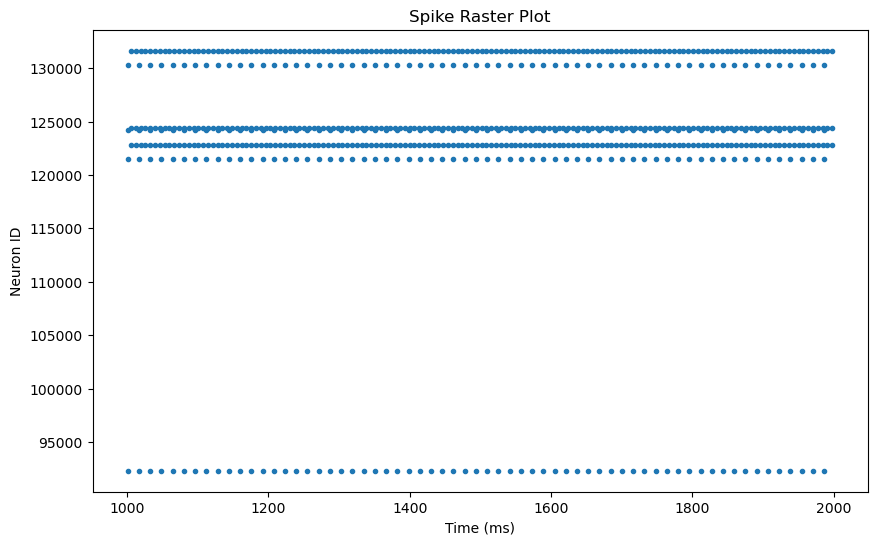

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(spike_times, spike_senders, '.')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron ID')
plt.title('Spike Raster Plot')
plt.show()

In [ ]:
max_id = max(max(neurons.keys()), max(post_id for _, post_id, _, _ in connections))
connection_matrix = np.zeros((max_id + 1, max_id + 1))

for pre_id, post_id, syn_count, _ in connections:
    connection_matrix[pre_id][post_id] += syn_count
    
plt.figure(figsize=(12,10))
sns.heatmap(connection_matrix, cmap='Yl0rRd', xticklabels=500, yticklabels=500)
plt.title('Connection Matrix Heatmap')
plt.xlabel('Post-synaptic Neuron ID')
plt.ylabel('Pre-synaptic Neuron ID')
plt.show()

MemoryError: Unable to allocate 28.3 PiB for an array with shape (63070841, 63070841) and data type float64

In [ ]:
neurons.keys()

dict_keys([720575940640168637, 720575940605607392, 720575940628181520, 720575940618133072, 720575940630467415, 720575940631109165, 720575940650935673, 720575940617110971, 720575940621952636, 720575940625847498, 720575940622175401, 720575940629794348, 720575940613749702, 720575940617296029, 720575940627184446, 720575940616135766, 720575940618981278, 720575940631016054, 720575940623036254, 720575940618726765, 720575940616992454, 720575940638081257, 720575940625972867, 720575940626887198, 720575940620043723, 720575940627082426, 720575940626635855, 720575940609964773, 720575940651986166, 720575940620249471, 720575940632041935, 720575940649237369, 720575940606573490, 720575940617232017, 720575940630387322, 720575940635368604, 720575940632959583, 720575940638914944, 720575940605380274, 720575940631619384, 720575940632131740, 720575940640437133, 720575940640978421, 720575940631662648, 720575940633814297, 720575940633601444, 720575940631679530, 720575940617780241, 720575940632879917, 720575940